In [1]:
import numpy as np
from scipy import stats
import random
from sklearn.utils import shuffle

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.utils import plot_model

import os
import sys
import glob
import time

import matplotlib.pyplot as plt
import seaborn as sns
from IPython import display
from IPython.display import Image
import imageio

# ----------------------------------------------
# ######## En local ############
path_dir = os.getcwd()
from config.utils import *


In [2]:
import pandas as pd
df = pd.read_csv('./data/images_mnist_10K.csv', header= None)
data_raw= np.array(df)
N_DATA = data_raw.shape[0]
DATA_DIM= data_raw.shape[1]


In [3]:
# change the range of data to [-1,1]
data= data_raw/255.
data = 2*data-1
dataset_train = data

## 1. GAN

In [4]:
def build_generator(latent_dim, n_neurons, data_dim=DATA_DIM):
    """
    Construction du générateur
    
    Parameters
    ----------
    latent_dim: int
        Dimension de la variable latente
    n_neurons: int
        Nombre de neurones dans la couche cachée
    data_dim: int
        Dimension de l'espace des données 

    Returns
    -------
    tf.Model
        Générateur du GAN
    """    
    model = tf.keras.Sequential(name="Generator")
    model.add(layers.Dense(n_neurons, input_shape=(latent_dim,), bias_initializer="glorot_normal"))
    
    model.add(layers.LeakyReLU(alpha=0.1))

    model.add(layers.Dense(data_dim, bias_initializer="glorot_normal"))
    return model


In [5]:
def build_discriminator(n_neurons, data_dim=DATA_DIM):
    """
    Construction du discriminateur
    
    Parameters
    ----------
    n_neurons: int
        Nombre de neurones dans les couches cachées
    data_dim: int
        Dimension de l'espace des données

    Returns
    -------
    tf.Model
        Discriminateur du GAN
    """
    model = tf.keras.Sequential(name="Discriminator")
    model.add(layers.Dense(n_neurons, input_shape=(DATA_DIM,), bias_initializer="glorot_normal", 
                           kernel_initializer="glorot_normal"))
    model.add(layers.LeakyReLU(alpha=0.1))
    

    model.add(layers.Dense(n_neurons, bias_initializer="glorot_normal", kernel_initializer="glorot_normal"))
    model.add(layers.LeakyReLU(alpha=0.1))
    
    model.add(layers.Dense(units = 1, bias_initializer="glorot_normal", kernel_initializer="glorot_normal"))

    return model


In [6]:
def discriminator_loss(real_output, fake_output): 
    """
    Fonction de coût du discriminateur

    Parameters
    ----------
    real_output: arr
        Sorties du discriminateur D(x)
    fake_output: arr
        Sorties du générateur D(G(z))

    Returns
    -------
    float
        Moyenne des fonctions de coûts dans le batch
    """
    return -tf.reduce_mean(tf.math.log(tf.nn.sigmoid(real_output) ) + tf.math.log(1. - tf.nn.sigmoid(fake_output) ))
  
def generator_loss(fake_output):
    """
    Fonction de coût du générateur

    Parameters
    ----------
    fake_output: arr
        Sorties du générateur D(G(z))

    Returns
    -------
    float
        Moyenne des fonctions de coûts dans le batch
    """
    return -tf.reduce_mean(tf.math.log(tf.nn.sigmoid(fake_output) ))

In [7]:
@tf.function
def train_step(data_batch, noise_dim):
    """
    Calcul du gradient et mise à jour des paramètres à chaque itération

    Parameters
    ----------
    data_batch: arr
        Batch de données (x_1, ..., x_m)
    noise_dim: int
        Dimension de la variable latente
    """
    
    tf.random.set_seed(counter_seed)  # actualisation de la seed pour chaque train_step 
    batch_size = data_batch.shape[0]
    
    # Entrainement du Discriminateur
    noise = tf.random.uniform([batch_size, noise_dim],minval=-1.,maxval =1.)  # z = (z_1, .., z_m)
    with tf.GradientTape() as disc_tape:
        generated_data = generator(noise)  # G(z)  
        real_output = discriminator(data_batch)  # D(x)
        fake_output = discriminator(generated_data)  # D(G(z))

        disc_loss = discriminator_loss(real_output, fake_output)  # calcul de la loss du discriminateur
    
    # calcul du gradient
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    
    # mise à jour des paramètres
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))
        
    noise = tf.random.uniform([batch_size, noise_dim],minval=-1.,maxval=1.) # z = (z_1, .., z_m)
    with tf.GradientTape() as gen_tape:
        generated_data = generator(noise)  # G(z) 
        fake_output = discriminator(generated_data)  # D(G(z))
        
        gen_loss = generator_loss(fake_output)  # calcul de la loss du générateur
    
    # calcul du gradient
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    
    # mise à jour des paramètres
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    return

def evaluate(data, noise_test):
    """
    Evaluation de l'erreur du générateur et du discriminateur (à utiliser pour l'affichage
    à la fin de l'entrainement)
    
    Parameters
    ----------
    data: arr
        Données de taille n, x=(x_1,..., x_n)
    noise_test: arr
        Bruit de taille n, z=(z_1,..., z_n)
        
    Returns
    -------
    loss_G: float
        valeur de la fonction de coût du générateur
    loss_D: float
        valeur de la fonction de coût du discriminateur
    """
    
    generated_data = generator(noise_test) #G(z)
    real_output = discriminator(data)# D(X)
    fake_output = discriminator(generated_data) # D(G(z))
    
    loss_D = discriminator_loss(real_output, fake_output)
    loss_G = generator_loss(fake_output)

    return loss_G.numpy(), loss_D.numpy()

In [8]:
tf.random.set_seed(1234)
np.random.seed(1234)
counter_seed = 0

# Choix des paramètres d'entrainement:
BATCH_SIZE = 50
LATENT_DIM = 100  
EPOCHS =  500   # 1000
NEURONS_G = 256
NEURONS_D = 256

# Construction du GAN
generator = build_generator(LATENT_DIM, NEURONS_G)
discriminator = build_discriminator(NEURONS_D)
generator_optimizer = tf.keras.optimizers.Adam(learning_rate=2e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate=2e-4)

# pour l'affichage
list_loss_G_train=[]
list_loss_D_train=[]


np.random.seed(1234)
noise_test = np.random.uniform(-1.,1.,size=(N_DATA, LATENT_DIM))
# évaluation sur toutes les données avec un bruit test fixe
loss_G, loss_D = evaluate(dataset_train, noise_test)  
list_loss_G_train.append(loss_G)
list_loss_D_train.append(loss_D)

print(loss_G, loss_D)

0.7577291 1.2181408


In [9]:
# Boucle d'entraînement:
print("Début de l'entraînement ...")

# division des données en batch de taille BATCH_SIZE
data_batches = tf.data.Dataset.from_tensor_slices(dataset_train).batch(BATCH_SIZE)

for epoch in range(1, EPOCHS+1):
    start_time= time.time()
    counter_seed+=1
    
    for data_batch in data_batches:
        counter_seed += 1
        train_step(data_batch, LATENT_DIM)
    
    if (epoch) % 10 == 0:    
        # évaluation à epoch modulo 10 sur toutes les données avec un bruit test fixe
        loss_G, loss_D = evaluate(dataset_train, noise_test)  
        list_loss_G_train.append(loss_G)
        list_loss_D_train.append(loss_D)
        
        time_epoch = time.time() - start_time
        display.clear_output(wait=True)
        print("Epoch {} ({:.2f} sec): Loss Generateur={:.3f}, Loss Discriminateur={:.3f}".format(\
            epoch, time_epoch, loss_G, loss_D))
        
    if (epoch %10) == 0:
        # sauvegarde les modèles 10 fois durant l'entraînement 
        generator.save(os.path.join(path_dir, "models", "mnist", "generator-N{}-Ldim{}-epoch{}-bs{}.h5".format(
            N_DATA, LATENT_DIM, epoch, BATCH_SIZE)))
            
        discriminator.save(os.path.join(path_dir,"models", "mnist", "discriminator-N{}-Ldim{}-epoch{}-bs{}.h5".format(
            N_DATA, LATENT_DIM, epoch, BATCH_SIZE)))
        
print("Fin de l'entraînement.")

Epoch 50 (2.03 sec): Loss Generateur=1.824, Loss Discriminateur=0.768
Fin de l'entraînement.


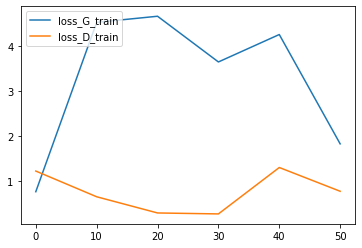

In [10]:
x = np.array(range(len(list_loss_G_train)))*10
plt.plot(x, list_loss_G_train, label="loss_G_train",)
plt.plot(x, list_loss_D_train, label="loss_D_train")
plt.legend(loc="upper left")

In [12]:
# utitlse les generators et discirminators sauvegardés
read_epochs=50
generator_model_file_name =os.path.join(path_dir, "models", "mnist", "generator-N{}-Ldim{}-epoch{}-bs{}.h5".format(
            N_DATA, LATENT_DIM, read_epochs, BATCH_SIZE))
generator = tf.keras.models.load_model(generator_model_file_name)

discriminator_model_file_name =os.path.join(path_dir,"models", "mnist", "discriminator-N{}-Ldim{}-epoch{}-bs{}.h5".format(
            N_DATA, LATENT_DIM, read_epochs, BATCH_SIZE))
discriminator = tf.keras.models.load_model(discriminator_model_file_name)

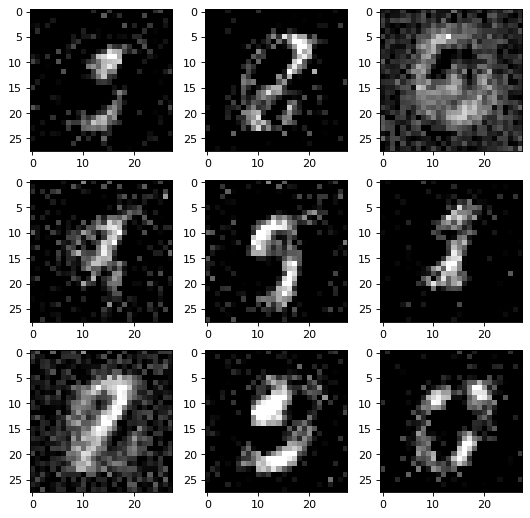

In [13]:
fake = generator(noise_test[:9])

fake = np.array(fake)
fake=(fake +1)/2. *255
fake[fake <0]=0
fake[fake>255]=255
fake=fake.astype(int)
arran =[331,332,333,334,335,336,337,338,339]
plt.figure(figsize=(8,8), dpi=80)
plt.figure(1)
for i in range(9):
    image = fake[i].reshape(28,28)
    ax=plt.subplot(arran[i])
    ax.imshow(image, cmap='gray')
    
plt.show()

## 2 WGAN

We make following changements:

- No log in the loss. No sigmoid for D.

- Clip the weight of D.

- Use RMSProp instead of ADAM

In [14]:
def discriminator_loss_wgan(real_output, fake_output): 

    return -tf.reduce_mean(real_output) + tf.reduce_mean(fake_output)
  
def generator_loss_wgan(fake_output):

    return -tf.reduce_mean(fake_output)

In [16]:
@tf.function
def train_step_wgan(data_batch, noise_dim, c = 0.01, n_critic = 5):
    """
    Calcul du gradient et mise à jour des paramètres à chaque itération

    Parameters
    ----------
    data_batch: arr
        Batch de données (x_1, ..., x_m)
    noise_dim: int
        Dimension de la variable latente
    """
    
    tf.random.set_seed(counter_seed)  # actualisation de la seed pour chaque train_step 
    batch_size = data_batch.shape[0]
    
    for _ in range(n_critic):
        # Entrainement du Discriminateur
        noise = tf.random.uniform([batch_size, noise_dim],minval=-1.,maxval =1.)  # z = (z_1, .., z_m)
        with tf.GradientTape() as disc_tape:
            generated_data = generator_wgan(noise)  # G(z)  
            real_output = discriminator_wgan(data_batch)  # D(x)
            fake_output = discriminator_wgan(generated_data)  # D(G(z))

            disc_loss = discriminator_loss_wgan(real_output, fake_output)  # calcul de la loss du discriminateur

        # calcul du gradient
        gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator_wgan.trainable_variables)

        # mise à jour des paramètres
        discriminator_optimizer_wgan.apply_gradients(zip(gradients_of_discriminator, discriminator_wgan.trainable_variables))

        # clip the weight of D
        for p in discriminator_wgan.trainable_variables:
            p.assign(tf.clip_by_value(p, -c, c))
        
        
    # Entrainement du Générateur
    noise = tf.random.uniform([batch_size, noise_dim],minval=-1.,maxval=1.) # z = (z_1, .., z_m)
    with tf.GradientTape() as gen_tape:
        generated_data = generator_wgan(noise)  # G(z) 
        fake_output = discriminator_wgan(generated_data)  # D(G(z))
        
        gen_loss = generator_loss_wgan(fake_output)  # calcul de la loss du générateur
    
    # calcul du gradient
    gradients_of_generator = gen_tape.gradient(gen_loss, generator_wgan.trainable_variables)
    
    # mise à jour des paramètres
    generator_optimizer_wgan.apply_gradients(zip(gradients_of_generator, generator_wgan.trainable_variables))
    return

def evaluate_wgan(data, noise_test):
    """
    Evaluation de l'erreur du générateur et du discriminateur (à utiliser pour l'affichage
    à la fin de l'entrainement)
    
    Parameters
    ----------
    data: arr
        Données de taille n, x=(x_1,..., x_n)
    noise_test: arr
        Bruit de taille n, z=(z_1,..., z_n)
        
    Returns
    -------
    loss_G: float
        valeur de la fonction de coût du générateur
    loss_D: float
        valeur de la fonction de coût du discriminateur
    """
    
    generated_data = generator_wgan(noise_test) #G(z)
    real_output = discriminator_wgan(data)# D(X)
    fake_output = discriminator_wgan(generated_data) # D(G(z))
    
    loss_D = discriminator_loss_wgan(real_output, fake_output)
    loss_G = generator_loss_wgan(fake_output)

    return loss_G.numpy(), loss_D.numpy()

In [17]:
tf.random.set_seed(1234)
np.random.seed(1234)
counter_seed = 0

# Choix des paramètres d'entrainement:
BATCH_SIZE = 50
LATENT_DIM = 100  
EPOCHS =  500   # 1000
NEURONS_G = 256
NEURONS_D = 256

# Construction du GAN
generator_wgan = build_generator(LATENT_DIM, NEURONS_G)
discriminator_wgan = build_discriminator(NEURONS_D)
generator_optimizer_wgan = tf.keras.optimizers.RMSprop(learning_rate=2e-4)
discriminator_optimizer_wgan = tf.keras.optimizers.RMSprop(learning_rate=2e-4)

# pour l'affichage
list_loss_G_train_wgan=[]
list_loss_D_train_wgan=[]


np.random.seed(1234)
noise_test = np.random.uniform(-1.,1.,size=(N_DATA, LATENT_DIM))
# évaluation sur toutes les données avec un bruit test fixe
loss_G_wgan, loss_D_wgan = evaluate_wgan(dataset_train, noise_test)  
list_loss_G_train_wgan.append(loss_G_wgan)
list_loss_D_train_wgan.append(loss_D_wgan)

print(loss_G_wgan, loss_D_wgan)

0.121014014 -0.41982096


In [20]:
# Boucle d'entraînement:
print("Début de l'entraînement ...")

# division des données en batch de taille BATCH_SIZE
data_batches = tf.data.Dataset.from_tensor_slices(dataset_train).batch(BATCH_SIZE)

for epoch in range(1, EPOCHS+1):
    start_time= time.time()
    counter_seed+=1
    
    for data_batch in data_batches:
        counter_seed += 1
        train_step_wgan(data_batch, LATENT_DIM)
    
    if (epoch) % 10 == 0:    
        # évaluation à epoch modulo 10 sur toutes les données avec un bruit test fixe
        loss_G_wgan, loss_D_wgan = evaluate_wgan(dataset_train, noise_test)  
        list_loss_G_train_wgan.append(loss_G_wgan)
        list_loss_D_train_wgan.append(loss_D_wgan)
        
        time_epoch = time.time() - start_time
        display.clear_output(wait=True)
        print("Epoch {} ({:.2f} sec): Loss Generateur={:.3f}, Loss Discriminateur={:.3f}".format(\
            epoch, time_epoch, loss_G_wgan, loss_D_wgan))
        
    if (epoch) % (EPOCHS/10) == 0:
        # sauvegarde les modèles 10 fois durant l'entraînement
        generator_wgan.save(os.path.join(path_dir, "models", "mnist", "generator-N{}-Ldim{}-epoch{}-bs{}.h5".format(
            N_DATA, LATENT_DIM, epoch, BATCH_SIZE)))
            
        discriminator_wgan.save(os.path.join(path_dir,"models", "mnist", "discriminator-N{}-Ldim{}-epoch{}-bs{}.h5".format(
            N_DATA, LATENT_DIM, epoch, BATCH_SIZE)))
        
print("Fin de l'entraînement.")

Epoch 50 (7.54 sec): Loss Generateur=-0.270, Loss Discriminateur=0.223
Fin de l'entraînement.


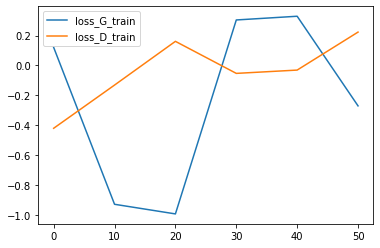

In [21]:
x = np.array(range(len(list_loss_G_train_wgan)))*10
plt.plot(x, list_loss_G_train_wgan, label="loss_G_train",)
plt.plot(x, list_loss_D_train_wgan, label="loss_D_train")
plt.legend(loc="upper left")

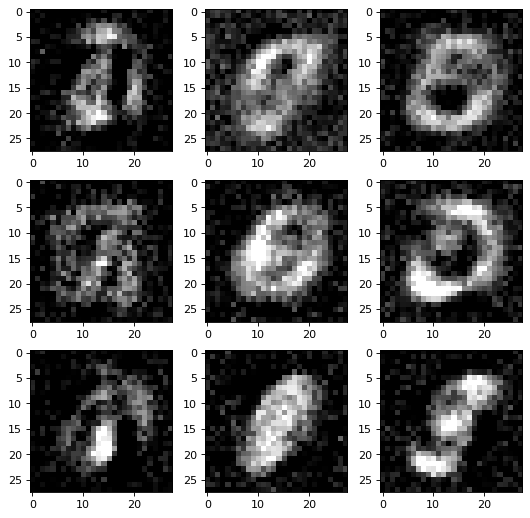

In [22]:
fake = generator_wgan(noise_test[:9])

fake = np.array(fake)
fake=(fake +1)/2. *255
fake[fake <0]=0
fake[fake>255]=255
fake=fake.astype(int)

# le résultat de wgan
arran =[331,332,333,334,335,336,337,338,339]
plt.figure(figsize=(8,8), dpi=80)
plt.figure(1)
for i in range(9):
    image = fake[i].reshape(28,28)
    ax=plt.subplot(arran[i])
    ax.imshow(image, cmap='gray')
    
plt.show()